In [2]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.io import read_image
from torchvision.models import ResNet50_Weights, resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import RandomCrop, Resize, transforms
from torchvision.transforms.functional import crop
from tqdm import tqdm
import datetime

In [3]:
class UAVIDDataset4K(Dataset):
    def __init__(self, path, is_train=True):
        directory = Path(path)
        if is_train:
            self.images = [
                str(x.absolute()) for x in directory.glob("uavid_train/**/Images/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("uavid_train/**/Labels/*.png")
            ]
        else:
            self.images = [
                str(x.absolute()) for x in directory.glob("uavid_val/**/Images/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("uavid_val/**/Labels/*.png")
            ]

        if len(self.images) is not len(self.labels):
            print("Number of images & label are not the same.")
            return

    def __len__(self):
        return len(self.images)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path)

    @staticmethod
    def resize_image(image):
        resizer = Resize([2160, 3840], antialias="True")
        return resizer(image)

    @staticmethod
    def label_0and1(label):
        return label.type(torch.float32)

    @staticmethod
    def image_0and1(image):
        return (image / 255).type(torch.float32)

    @staticmethod
    def mask_label(label):
        labels = []
        labels.append((label[0] == 0) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 64) & (label[2] == 128))
        labels.append((label[0] == 0) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 64) & (label[1] == 0) & (label[2] == 128))
        labels.append((label[0] == 192) & (label[1] == 0) & (label[2] == 192))
        labels.append((label[0] == 64) & (label[1] == 64) & (label[2] == 0))
        return torch.stack(labels)

    def __getitem__(self, index):
        image = self.decode_image(self.images[index])
        image = self.resize_image(image)
        image = self.image_0and1(image)

        label = self.decode_image(self.labels[index])
        label = self.resize_image(label)
        label = self.label_0and1(label)
        label = self.mask_label(label)

        return image, label

In [4]:
class UAVIDDataset(Dataset):
    def __init__(self, path, is_train=True):
        directory = Path(path)
        if is_train:
            self.images = [
                str(x.absolute()) for x in directory.glob("train/image/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("train/label/*.png")
            ]
        else:
            self.images = [
                str(x.absolute()) for x in directory.glob("test/image/*.png")
            ]
            self.labels = [
                str(x.absolute()) for x in directory.glob("test/label/*.png")
            ]

        if len(self.images) != len(self.labels):
            print("Number of images & label are not the same.")
            return

    def __len__(self):
        return len(self.images)

    @staticmethod
    def decode_image(image_path):
        return read_image(image_path)

    @staticmethod
    def resize_image(image):
        resizer = Resize([2160, 3840], antialias="True")
        return resizer(image)

    @staticmethod
    def label_0and1(label):
        return label.type(torch.float32)

    @staticmethod
    def image_0and1(image):
        return (image / 255).type(torch.float32)

    @staticmethod
    def mask_label(label):
        labels = []
        labels.append((label[0] == 0) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 0) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 64) & (label[2] == 128))
        labels.append((label[0] == 0) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 128) & (label[1] == 128) & (label[2] == 0))
        labels.append((label[0] == 64) & (label[1] == 0) & (label[2] == 128))
        labels.append((label[0] == 192) & (label[1] == 0) & (label[2] == 192))
        labels.append((label[0] == 64) & (label[1] == 64) & (label[2] == 0))
        return torch.stack(labels)

    def __getitem__(self, index):
        image = self.decode_image(self.images[index])
        i, j, h, w = RandomCrop.get_params(image, (256, 256))
        image = self.image_0and1(image)
        label = self.decode_image(self.labels[index])
        label = self.mask_label(label)
        label = self.label_0and1(label)

        # Crop image and label
        image = crop(image, i, j, h, w)
        label = crop(label, i, j, h, w)

        return image, label

In [5]:
dataset_labels = [
    "background",
    "building",
    "road",
    "tree",
    "vegetation",
    "moving_car",
    "stationary_car",
    "human",
]

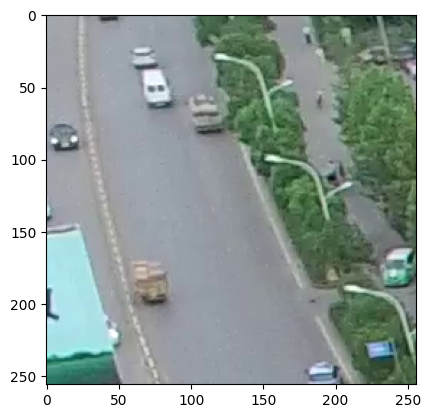

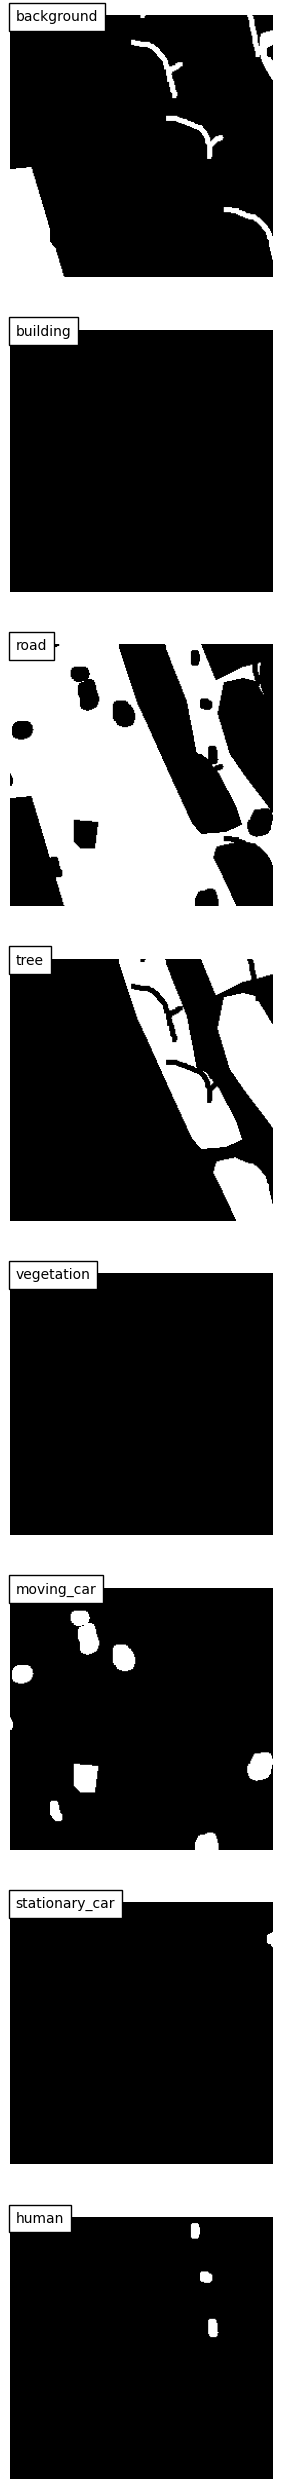

In [6]:
# training_data = UAVIDDataset4K(path="data/uavid_v1.5_official_release_image", is_train=True)
training_data = UAVIDDataset(
    path="/Users/babi/Programs/high_performance_analysis_system/data/processed_dataset/",
    is_train=True,
)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
train_feature, train_label = next(iter(train_dataloader))

plt.figure()
plt.imshow(torch.permute(train_feature[0], [1, 2, 0]))

figure, axes = plt.subplots(8, 1, figsize=(16, 32))
for i in range(8):
    axes[i].set_axis_off()
    axes[i].imshow(
        torch.permute(train_label, [0, 2, 3, 1]).numpy()[0, ..., i],
        cmap="gray",
        vmin=0,
        vmax=1,
    )
    axes[i].text(5, 5, dataset_labels[i], bbox={"facecolor": "white", "pad": 5})

In [7]:
class UNETNetwork(nn.Module):
    def __init__(self, numberClass):
        super().__init__()
        _resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = create_feature_extractor(
            _resnet50,
            {
                "relu": "feat1",
                "layer1": "feat2",
                "layer2": "feat3",
                "layer3": "feat4",
                "layer4": "feat5",
            },
        )
        self.upsampling_2x = nn.UpsamplingNearest2d(scale_factor=2)
        self.upsampling_2x_bilinear = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv5 = nn.Conv2d(
            in_channels=2048, out_channels=1024, kernel_size=3, padding=1
        )
        self.conv6 = nn.Conv2d(
            in_channels=1024, out_channels=512, kernel_size=3, padding=1
        )
        self.conv7 = nn.Conv2d(
            in_channels=512, out_channels=256, kernel_size=3, padding=1
        )
        self.conv8 = nn.Conv2d(
            in_channels=256, out_channels=128, kernel_size=3, padding=1
        )
        self.convfinal = nn.Conv2d(
            in_channels=128, out_channels=numberClass, kernel_size=1
        )

    def forward(self, x):
        backbone_output = self.backbone(x)
        feat2, feat3, feat4, feat5 = (
            backbone_output["feat2"],
            backbone_output["feat3"],
            backbone_output["feat4"],
            backbone_output["feat5"],
        )
        feat4to6 = self.upsampling_2x_bilinear(self.conv5(feat5).relu())
        feat3to7 = self.upsampling_2x_bilinear(self.conv6(feat4 + feat4to6).relu())
        feat2to8 = self.upsampling_2x_bilinear(self.conv7(feat3 + feat3to7).relu())
        featout = self.upsampling_2x_bilinear(self.conv8(feat2 + feat2to8).relu())
        return self.upsampling_2x_bilinear(self.convfinal(featout))

In [8]:
def dice_loss(
    pred: torch.Tensor,
    target: torch.Tensor,
    epsilon=1e-9,
):
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    nominator = 2 * torch.matmul(pred_flat, target_flat)
    denominator = torch.sum(pred_flat) + torch.sum(target_flat)
    return 1 - ((nominator + epsilon) / (denominator + epsilon))


def total_loss(pred: torch.Tensor, target: torch.Tensor):
    return torch.nn.functional.cross_entropy(
        pred,
        target,
    ) + dice_loss(
        pred.softmax(1),
        target,
    )

In [9]:
training_data = UAVIDDataset(
    path="/Users/babi/Programs/high_performance_analysis_system/data/processed_dataset/",
    is_train=True,
)
train_dataloader = DataLoader(
    training_data,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
)
model = UNETNetwork(numberClass=8).to("mps")
optimizer_sgd = torch.optim.SGD(params=model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to("mps")
timestamp = datetime.datetime.now().strftime(r"%Y%m%d_%H%M%S")
writer = SummaryWriter("data/training/train_{}".format(timestamp))

/Users/babi/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/babi/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/babi/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/babi/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [11]:
model = torch.load("model.pt")

In [18]:
for epoch in range(4, 10):
    model.train(True)
    running_loss = 0.0
    for idx, data in enumerate(tqdm(train_dataloader)):
        inputs: torch.Tensor
        labels: torch.Tensor
        inputs, labels = data
        optimizer.zero_grad()
        optimizer_sgd.zero_grad()

        inputs = inputs.to("mps")
        labels = labels.to("mps")

        inputs = normalize(inputs)
        outputs = model(inputs)

        loss = total_loss(outputs, labels)
        loss.backward()

        optimizer_sgd.step()
        running_loss += loss.item()

        if idx % 500 == 499:
            current_training_sample = epoch * len(train_dataloader) + idx + 1
            writer.add_scalar("Loss/train", running_loss / 500, current_training_sample)
            print(f"Loss: {running_loss / 500}")
            running_loss = 0.0

 28%|██▊       | 500/1800 [02:34<06:36,  3.28it/s]

Loss: 1.0054940999150277


 56%|█████▌    | 1000/1800 [05:07<04:08,  3.22it/s]

Loss: 0.9840239785313606


 83%|████████▎ | 1500/1800 [07:39<01:30,  3.33it/s]

Loss: 0.9903043061494827


 28%|██▊       | 500/1800 [02:33<06:39,  3.25it/s]

Loss: 0.9548897218108178


 53%|█████▎    | 951/1800 [04:50<04:19,  3.27it/s]


KeyboardInterrupt: 

In [20]:
torch.save(model, "model.pt")


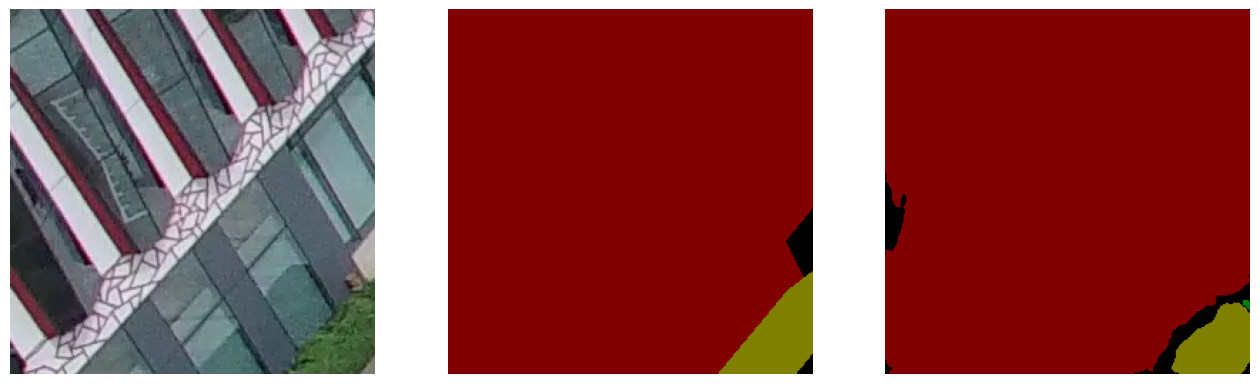

In [12]:
output_image = np.zeros([256, 256, 3], dtype=np.uint8)
output_image2 = np.zeros_like(output_image, dtype=np.uint8)
model.eval()
colors = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [128, 64, 128],
        [0, 128, 0],
        [128, 128, 0],
        [64, 0, 128],
        [192, 0, 192],
        [64, 64, 0],
    ],
    dtype=np.uint8,
)

test_data = UAVIDDataset(
    path="/Users/babi/Programs/high_performance_analysis_system/data/processed_dataset/",
    is_train=False,
)
test_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
test_feature, test_label = next(iter(test_dataloader))

fig, axes = plt.subplots(1, 3, figsize=(16, 9))

with torch.no_grad():
    outputs = model(normalize(test_feature.to("mps")))
    outputs = outputs.to("cpu").softmax(axis=1)
    for i in range(8):
        mask = test_label[0, i] == 1
        output_image[mask] = colors[i]

        mask2 = outputs[0, i] > 0.5
        output_image2[mask2] = colors[i]

    axes[0].set_axis_off()
    axes[1].set_axis_off()
    axes[2].set_axis_off()
    axes[0].imshow(torch.permute(test_feature, [0, 2, 3, 1])[0])
    axes[1].imshow(output_image)
    axes[2].imshow(output_image2)